# Academic Essay Score Prediction with CORAL + DeBERTa: Code Explanation

This document explains the full training pipeline used for ordinal regression on IELTS essay bands using a CORAL (Cumulative Ordinal Regression) head on top of DeBERTa-v3-base.
The model predicts cumulative logits, calibrates thresholds, and evaluates using QWK, RMSE, F1, and accuracy.

**Current model performance:**

* QWK: ~0.60

* RMSE: ~0.70

These results are consistent with expectations for small/medium-sized essay datasets and indicate that the model predicts within roughly 0.7 bands of the true score on average.


## 0. Set up

In [1]:
!pip install -q transformers datasets evaluate scikit-learn accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [2]:
!pip install fastapi uvicorn pyngrok nest-asyncio "uvicorn[standard]" --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 40.1 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, AutoTokenizer, DataCollatorWithPadding, EarlyStoppingCallback
import os, re, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import Dataset, DatasetDict
from textwrap import shorten
import seaborn as sns

## 1. Load Datasets


Two datasets have been merged for training/testing.

* IELTS Writing Task 2 Evaluation (Hugging Face)

* IELTS Writing Scored Essays Dataset(Kaggle)




---



[IELTS Writing Task 2 Evaluation (Hugging Face)](https://huggingface.co/datasets/chillies/IELTS-writing-task-2-evaluation) after cleaning the leakage has been loaded.

In [4]:
from google.colab import drive

drive.mount('/content/drive')

# Load Hugging Face Datasets
train_path = '/content/drive/MyDrive/train_ielts4.csv'
test_path  = '/content/drive/MyDrive/test_ielts4.csv'

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

Mounted at /content/drive


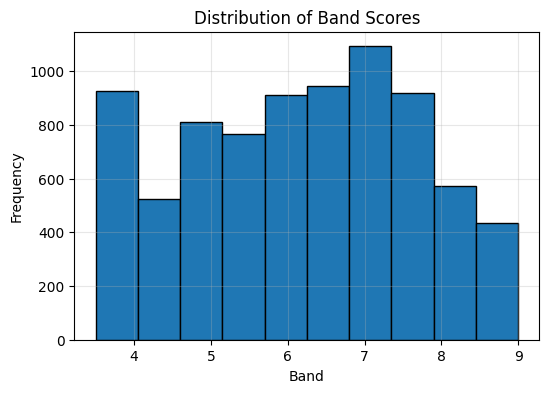

In [5]:
# Plot histogram of 'band'
plt.figure(figsize=(6, 4))
plt.hist(df_train['band'], bins=10, edgecolor='black')
plt.title('Distribution of Band Scores')
plt.xlabel('Band')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

[IELTS Writing Scored Essays Dataset(Kaggle)](https://www.kaggle.com/datasets/mazlumi/ielts-writing-scored-essays-dataset), only remaining essay in task 2, has been loaded.

In [6]:
# Load Kaggle Datasets
path = '/content/drive/MyDrive/ielts_writing_dataset.csv'
df = pd.read_csv(path)

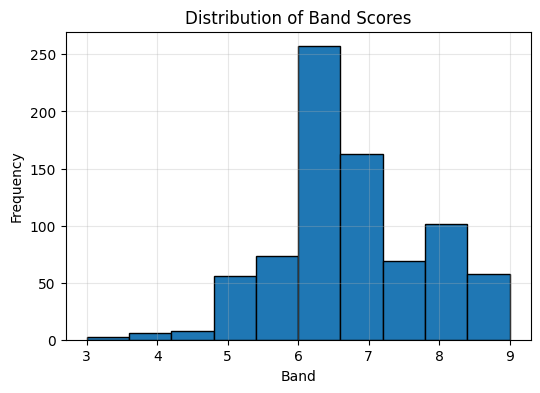

In [7]:
# Only remain task 2 essay
df = df[df['Task_Type'] == 2][['Question', 'Essay', 'Overall']]

# Rename columns
df = df.rename(columns={
    'Question': 'topic',
    'Essay': 'essay',
    'Overall': 'band'})

# Plot histogram of 'band'
plt.figure(figsize=(6, 4))
plt.hist(df['band'], bins=10, edgecolor='black')
plt.title('Distribution of Band Scores')
plt.xlabel('Band')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

## 2. Datasets Preprocessing
### 2.1. Combine the datasets into unified format.

In [8]:
df_clean_train = df_train[['topic', 'essay', 'band', 'label']].copy()
df_clean_test  = df_test[['topic', 'essay', 'band', 'label']].copy()

In [9]:
# Combine df with df_clean_train
df_clean_train = pd.concat([df_clean_train, df], ignore_index=True)

In [10]:
# Collapse extremes and merge pairs
def bucket_band(b):
    if b <= 4.5:
        return 4.0
    elif b in [9.0, 8.5, 8.0]:
        return 8.0
    elif b in [5.0, 5.5]:
        return 5.0
    elif b in [6.0, 6.5]:
        return 6.0
    elif b in [7.0, 7.5]:
        return 7.0
    else:
        return b

df_clean_train['band'] = df_clean_train['band'].apply(bucket_band)
df_clean_test['band']  = df_clean_test['band'].apply(bucket_band)

# Create integer labels
unique_bands = sorted(pd.concat([df_clean_train['band'], df_clean_test['band']]).unique())
band_to_id = {b: i for i, b in enumerate(unique_bands)}
id_to_band = {i: b for b, i in band_to_id.items()}

df_clean_train['label'] = df_clean_train['band'].map(band_to_id)
df_clean_test['label']  = df_clean_test['band'].map(band_to_id)

print("Updated band mapping:")
print(band_to_id)

Updated band mapping:
{np.float64(4.0): 0, np.float64(5.0): 1, np.float64(6.0): 2, np.float64(7.0): 3, np.float64(8.0): 4}


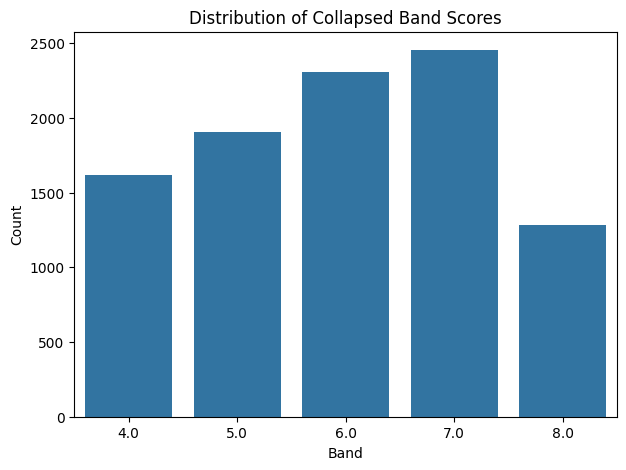

In [11]:
# Combine train and test to see the overall band distribution
df_all = pd.concat([df_clean_train, df_clean_test], ignore_index=True)

plt.figure(figsize=(7,5))
sns.countplot(x='band', data=df_all, order=sorted(df_all['band'].unique()))
plt.title('Distribution of Collapsed Band Scores')
plt.xlabel('Band')
plt.ylabel('Count')
plt.show()


In [12]:
# Train/val/test datasets
train_df, val_df = train_test_split(
    df_clean_train[["topic", "essay", "label"]],
    test_size=0.15,
    random_state=42,
    stratify=df_clean_train["label"],
)

test_df = df_clean_test[["topic", "essay", "label"]]

### 2.2. Merge Inputs and Tokenising with HF Dataset

In [18]:
# Build a single text input by combining topic + separator + essay
def build_text(row):
    return f"{row['topic']} {sep_token} {row['essay']}"

# Convert a pandas DataFrame into a HuggingFace Dataset
def to_hfds(df):
    texts  = df.apply(build_text, axis=1).tolist() # create merged text for each row
    labels = df["label"].tolist()                  # extract labels
    return Dataset.from_dict({"text": texts, "labels": labels})

# Create HF Datasets for each splits
train_ds = to_hfds(train_df)
val_ds   = to_hfds(val_df)
test_ds  = to_hfds(test_df)

# Tokenisation function applied to each batch of samples
def tok(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )

# Tokenize datasets and remove raw text
train_ds = train_ds.map(tok, batched=True, remove_columns=["text"])
val_ds   = val_ds.map(tok,   batched=True, remove_columns=["text"])
test_ds  = test_ds.map(tok,  batched=True, remove_columns=["text"])

Map:   0%|          | 0/7388 [00:00<?, ? examples/s]

Map:   0%|          | 0/1304 [00:00<?, ? examples/s]

Map:   0%|          | 0/878 [00:00<?, ? examples/s]

## 2. Pre-trained Model Settings

In [14]:
model_name = "microsoft/deberta-v3-base"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
max_length = 512
sep_token  = tokenizer.sep_token
num_classes = len(unique_bands)
dropout_rate = 0.3
n_dropout_samples = 4

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [15]:
# CORAL model
class CoralDeberta(nn.Module):
    def __init__(self,
                 model_name,
                 num_classes,
                 dropout_rate,
                 n_dropout_samples):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        hs = self.backbone.config.hidden_size
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hs, num_classes - 1)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.n_dropout_samples = n_dropout_samples

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]

        if self.training and self.n_dropout_samples > 1:
            logits_list = []
            for _ in range(self.n_dropout_samples):
                x = self.dropout(cls)
                logits_list.append(self.classifier(x))
            logits = torch.stack(logits_list, dim=0).mean(dim=0)
        else:
            x = self.dropout(cls)
            logits = self.classifier(x)

        outputs = {"logits": logits}

        if labels is not None:
            B, K1 = logits.size()
            ks = torch.arange(K1, device=labels.device).unsqueeze(0).expand(B, -1)
            y_cum = (labels.unsqueeze(1) > ks).float()
            outputs["loss"] = self.loss_fn(logits, y_cum)

        return outputs

model = CoralDeberta(
    model_name,
    num_classes=num_classes,
    dropout_rate=0.3,
    n_dropout_samples=4,
)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

## 3. Evaluation Metrics
Computes the evaluation metrics used during training, converting logits into predicted labels and calculating both classification (accuracy, macro F1, QWK) and regression-style metrics (RMSE, MAE).

In [16]:
# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()
    probs = 1.0 / (1.0 + np.exp(-logits))
    preds = (probs > 0.5).sum(axis=1).astype(int)

    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(labels, preds)

    return {
        "accuracy":  accuracy_score(labels, preds),
        "macro_f1":  f1_score(labels, preds, average="macro"),
        "qwk":       cohen_kappa_score(labels, preds, weights="quadratic"),
        "rmse":      rmse,
        "mae":       mae,
    }

## 4. Training Setup and Model Optimization

This section configures the HuggingFace Trainer with the chosen training arguments, including learning rate, batch size, number of epochs, and the evaluation strategy. The trainer then handles the full training loop, validation, metric tracking (using QWK as the selection criterion), and early stopping to prevent overfitting.

In [20]:
# Trainer
args = TrainingArguments(
    output_dir="ielts-band-coral",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="qwk",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

train_output = trainer.train()
print(trainer.evaluate())

/tmp/ipython-input-745612309.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Qwk,Rmse,Mae
1,0.432900,0.428930,0.393405,0.340257,0.569063,1.089901,0.786043
2,0.396200,0.426663,0.403374,0.346177,0.584768,1.069301,0.766104
3,0.354300,0.428469,0.411043,0.380392,0.600069,1.042060,0.742331
4,0.280400,0.509807,0.383436,0.375808,0.587286,1.073953,0.785276
5,0.236100,0.580379,0.386503,0.392854,0.590349,1.136065,0.819785


{'eval_loss': 0.4284692406654358, 'eval_accuracy': 0.4110429447852761, 'eval_macro_f1': 0.3803916354112432, 'eval_qwk': 0.6000693096756308, 'eval_rmse': 1.042060252841527, 'eval_mae': 0.7423312883435583, 'eval_runtime': 14.8219, 'eval_samples_per_second': 87.978, 'eval_steps_per_second': 10.997, 'epoch': 5.0}


## 5. Validation Calibration

Tunes a global probability threshold to convert CORAL outputs into discrete band predictions. By sweeping thresholds on the validation set and selecting the one that maximises QWK, the model's ordinal predictions are calibrated for optimal scoring accuracy.

In [21]:
# Validation calibration
with torch.no_grad():
    val_out = trainer.predict(val_ds)

logits_val = val_out.predictions
y_val      = np.array(val_ds["labels"])
probs_val  = 1.0 / (1.0 + np.exp(-logits_val))
K1         = probs_val.shape[1]

# Global threshold search
ths = np.linspace(0.30, 0.60, 31)
best_th, best_qwk = 0.5, -1.0

for t in ths:
    preds = (probs_val > t).sum(axis=1).astype(int)
    qwk   = cohen_kappa_score(y_val, preds, weights="quadratic")
    if qwk > best_qwk:
        best_th, best_qwk = t, qwk

print(f"Best global val threshold: {best_th:.3f} (QWK={best_qwk:.5f})")

Best global val threshold: 0.480 (QWK=0.60198)


## 6. Per-Class Threshold Calibration

After finding a global threshold, this step optimizes class-specific cutoffs for each CORAL output dimension. By iteratively adjusting thresholds to maximize validation QWK, the model achieves more precise ordinal calibration than using a single global value.

In [22]:
# Per-threshold search
cutoffs = np.full(K1, best_th)

def preds_from_cutoffs(prob_mat, cuts):
    return (prob_mat > cuts[None, :]).sum(axis=1).astype(int)

def qwk_cutoffs(cuts):
    return cohen_kappa_score(
        y_val,
        preds_from_cutoffs(probs_val, cuts),
        weights="quadratic",
    )

grid = np.arange(0.35, 0.66, 0.01)
best_cut_qwk = qwk_cutoffs(cutoffs)

for _ in range(4):
    improved = False
    for k in range(K1):
        best_local = cutoffs[k]
        best_local_q = best_cut_qwk
        for g in grid:
            trial = cutoffs.copy()
            trial[k] = g
            q = qwk_cutoffs(trial)
            if q > best_local_q:
                best_local_q = q
                best_local   = g
        if best_local != cutoffs[k]:
            cutoffs[k] = best_local
            best_cut_qwk = best_local_q
            improved = True
    if not improved:
        break

print("Per-threshold cutoffs:", np.round(cutoffs, 3))
print("Val QWK with per-threshold:", round(best_cut_qwk, 6))

Per-threshold cutoffs: [0.64 0.54 0.48 0.36]
Val QWK with per-threshold: 0.615487


## 7. Final Model Saving and Test Evaluation

The model, tokenizer, and calibrated cutoffs are saved, and then the final performance is measured on the test set. Both classification metrics (Accuracy, F1, QWK) and regression-style metrics (RMSE, RAE) are reported for a complete view of how well the model generalises.

In [23]:
# Save model + cutoffs
os.makedirs(args.output_dir, exist_ok=True)
trainer.save_model(args.output_dir)
tokenizer.save_pretrained(args.output_dir)
np.save(f"{args.output_dir}/coral_cutoffs.npy", cutoffs)
print("Saved model + cutoffs to:", args.output_dir)

# Final TEST evaluation
with torch.no_grad():
    test_out = trainer.predict(test_ds)

logits_test = test_out.predictions
y_test      = np.array(test_ds["labels"])
probs_test  = 1.0 / (1.0 + np.exp(-logits_test))

y_pred_cal = preds_from_cutoffs(probs_test, cutoffs)

# Main metrics
qwk_test = cohen_kappa_score(y_test, y_pred_cal, weights="quadratic")
acc_test = accuracy_score(y_test, y_pred_cal)
f1_test  = f1_score(y_test, y_pred_cal, average="macro")

# Simple RMSE + RAE
mse_test  = mean_squared_error(y_test, y_pred_cal)
rmse_test = np.sqrt(mse_test)

y_mean  = y_test.mean()
rae_test = np.sum(np.abs(y_test - y_pred_cal)) / np.sum(np.abs(y_test - y_mean))

print("\n=== Final TEST (calibrated) ===")
print(
    f"Accuracy: {acc_test:.4f} | Macro F1: {f1_test:.4f} | QWK: {qwk_test:.6f} | "
    f"RMSE: {rmse_test:.4f} | RAE: {rae_test:.4f}"
)


Saved model + cutoffs to: ielts-band-coral



=== Final TEST (calibrated) ===
Accuracy: 0.4157 | Macro F1: 0.3911 | QWK: 0.595469 | RMSE: 1.0915 | RAE: 0.6994


In [24]:
# Inference helper
def predict_band_calibrated(
    topic,
    essay,
    cutoffs=cutoffs,
    tok=tokenizer,
    mdl=model,
    max_len=max_length,
):
    text = f"{topic} {sep_token} {essay}"

    enc = tok(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_len,
    )

    # keep only keys the model actually supports
    enc = {
        k: v.to(next(mdl.parameters()).device)
        for k, v in enc.items()
        if k in ["input_ids", "attention_mask"]
    }

    mdl.eval()
    with torch.no_grad():
        logits = mdl(**enc)["logits"].cpu().numpy()[0]

    probs   = 1.0 / (1.0 + np.exp(-logits))
    pred_id = int((probs > cutoffs).sum())
    return id_to_band[pred_id]

In [25]:
topic = "Some people believe that in the future, most cities will become unlivable due to pollution and overcrowding. Others think technological innovation will solve these problems. Discuss both sides and give your own opinion"
essay = "In modern society, the debate over whether cities will remain livable in the future is intensifying. While some firmly assert that pollution and overcrowding will cause cities to be uninhabitable, others disagree. As for me, I wholeheartedly agree with the latter stand. This essay will discuss both points of view and argue in favour of the latter stand. On the one hand, advocates for the idea that cities will become unlivable present several compelling reasons. Supporters of this perspective maintain that the rapid growth of population in urban areas leads to overcrowding, contributing to a decline in the quality of life among citizens. For instance, in Seoul, housing prices are rising quickly and public transport is often overcrowded during rush hours, which shows how population density affects people’s daily lives. High prices of housing due to increased demand for housing and increased number of people using public transport causes citizens to be stressed out and feel drained on a daily basis. Furthermore, they argue that there has been industrialisation alongside an increase in the number of factories and vehicle emissions, which leads air pollution to be worse every year. Undoubtedly, heavy pollution in residential areas will threaten public health and the environment in the long term. Given these arguments, some individuals firmly believe that cities in the future will be highly polluted and crowded for sustainable lifestyles. On the other hand, my personal opinion is that technological innovation can allow pervasive problems to be effectively addressed. One of the most convincing reasons for this stance is that the development of technology prevents urban life from being deteriorated and polluted by reducing pollution and improving urban life. To elaborate, the use of renewable energy and electric vehicles can encourage cities to be more sustainable. Additionally, with continuous innovation and government support, cities can eliminate main factors for pollution, such as imposing green taxes, becoming cleaner and more efficient places to live. Taking into account the aforementioned points, I find these counterarguments more persuasive. In summary, it’s undeniable that this topic elicits a range of opinions. Having weighed the evidence and arguments, I fully support the view that technological advancement will enable cities to remain livable despite pollution and overpopulation"

predict_band_calibrated(topic, essay)

np.float64(7.0)